# Analysis Relation SII in noise & AC  and BC direct thresholds in the situation Sbcd65_Nbest65

25 January 2021 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import linregress as linregress

In [2]:
def read_AC_thresholds():
    # read measured thresholds
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/AC_thresholds.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name=0, header=0, index_col= 1, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    type_dict = {'Device': 'str',
             'AC_125':'float32', 'AC_250':'float32', 'AC_500':'float32', 
             'AC_1000': 'float32', 'AC_2000': 'float32', 
             'AC_4000': 'float32', 'AC_8000': 'float32'}
    df = df.astype(type_dict)
    new_dict ={'AC_500': 'AC_500_Hz', 'AC_1000': 'AC_1000_Hz', 
               'AC_2000': 'AC_2000_Hz', 'AC_4000': 'AC_4000_Hz'}
    df = df.rename(columns=new_dict)
    df = df.fillna(pd.NA)
    return df

In [3]:
def present_AC_thresholds():
    ac = read_AC_thresholds()
    ac1 = ac[['Device', 'AC_500_Hz', 'AC_1000_Hz', 
              'AC_2000_Hz', 'AC_4000_Hz']].copy()
    pta = ac1.iloc[:, 1:].mean(axis='columns')
    ac1.insert(5, column= 'PTA (0.5-4 kHz)', value=pta)
    pta_hf = ac1.iloc[:, 2:].mean(axis='columns')
    ac1.insert(6, column= 'PTA_HF (1-4 kHz)', value=pta_hf)
    return ac1

In [4]:
def read_BC_direct():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/BC_direct_thresholds.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name=0, header=0, index_col= 1, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    type_dict = {'Device': 'str',
             'BCd_250':'float32', 'BCd_250':'float32', 'BCd_500':'float32', 
             'BCd_1000': 'float32', 'BCd_1500': 'float32', 'BCd_2000': 'float32', 'BCd_3000': 'float32', 
             'BCd_4000': 'float32'}
    new_dict ={'BCd_500': 'BCd_500_Hz', 'BCd_1000': 'BCd_1000_Hz', 
               'BCd_2000': 'BCd_2000_Hz', 'BCd_4000': 'BCd_4000_Hz'}
    df = df.astype(type_dict)
    df = df.rename(columns=new_dict)
    df = df.fillna(pd.NA)
    return df

In [5]:
def present_BCdirect_thresholds():
    bc = read_BC_direct()
    bc1 = bc[['Device', 'BCd_500_Hz', 'BCd_1000_Hz', 'BCd_2000_Hz', 'BCd_4000_Hz']].copy()
    pta = bc1.iloc[:, 1:].mean(axis='columns')
    bc1.insert(5, column= 'PTA (0.5-4 kHz)', value=pta)
    pta_hf = bc1.iloc[:, 2:].mean(axis='columns')
    bc1.insert(6, column= 'PTA_HF (1-4 kHz)', value=pta_hf)
    bc1.dropna(inplace=True)
    return bc1

In [6]:
def read_SII():
    f_in =  '/media/guido/LACIE/Cingle_Guido/Master/SII_Sbcd65_Nbest65.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='SII_Sbcd65_Nbest65', header=0, index_col= 1, nrows=85)
    df = df.drop(['Unnamed: 0',], axis=1)
    df = df.fillna(pd.NA)
    return df

In [7]:
def select_bp110(df):
    # select BP110 data
    is_bp110 =  df['Device']=='BP110'
    df_bp110 = df[is_bp110]
    df_bp110.pop('Device')
    return(df_bp110)

In [8]:
def select_bh5(df):
    # select BAHA5P data
    is_baha5p =  df['Device']=='BAHA5P'
    df_baha5p = df[is_baha5p]
    df_baha5p.pop('Device')
    return(df_baha5p)

In [9]:
def select_cases():
    sii = read_SII()
    idx = sii.index
    return idx

In [10]:
def select_ac_thresholds():
    act = present_AC_thresholds()
    idx = select_cases()
    act1 = act.loc[idx]
    return act1

In [11]:
def select_bc_thresholds():
    bct = present_BCdirect_thresholds()
    idx = select_cases()
    bct1 = bct.loc[idx]
    return bct1

In [12]:
# SII combi per Device type, as numpy array, presented as tuple
def sii_device():
    sii = read_SII()
    sii_bp110 = (select_bp110(sii).iloc[:, 2]).to_numpy(dtype='float')
    sii_bh5 = (select_bh5(sii).iloc[:, 2]).to_numpy(dtype='float')
    t = (sii_bp110, sii_bh5)
    return t

In [13]:
# AC thresholds per Device type, as numpy array, presented as tuple
def act_device():
    act = select_ac_thresholds()
    act_bp110 = select_bp110(act)
    act_bh5 = select_bh5(act)
    t = (act_bp110, act_bh5)
    return t

In [14]:
# BC direct thresholds per Device type, as numpy array, presented as tuple
def bct_device():
    bct = select_bc_thresholds()
    bct_bp110 = select_bp110(bct)
    bct_bh5 = select_bh5(bct)
    t = (bct_bp110, bct_bh5)
    return t

In [15]:
# lin. reg. SII combination path (si) function thresholds (df)
def lreg_SII(thr, si):
    l = list(thr.columns)
    d = dict()
    for j in range(6):
        thres = (thr.iloc[:, j]).to_numpy(dtype='float')
        lrgrs = linregress(thres, si)
        r = lrgrs[2]
        r2 = round(r**2, 3)
        r = round(r, 3)
        p = round(lrgrs[3], 3)
        se = round(lrgrs[4], 4)
        print(l[j], 'r square =', r2, ' r =', r, ' p =', p, ' se =', se)
        de = {l[j] : (r, r2)}
        d.update(de)
    df = pd.DataFrame.from_dict(d, orient='index')
    return df

In [16]:
(sii_bp110, sii_bh5) = sii_device()
(act_bp110, act_bh5) = act_device()
(bct_bp110, bct_bh5) = bct_device()

In [17]:
# BAHA5P: relation sii combination path vs. AC thresholds
lr_bh5_ac = lreg_SII(act_bh5, sii_bh5)

AC_500_Hz r square = 0.025  r = -0.159  p = 0.36  se = 0.001
AC_1000_Hz r square = 0.013  r = -0.113  p = 0.518  se = 0.001
AC_2000_Hz r square = 0.436  r = 0.661  p = 0.0  se = 0.0007
AC_4000_Hz r square = 0.245  r = 0.495  p = 0.002  se = 0.0004
PTA (0.5-4 kHz) r square = 0.133  r = 0.365  p = 0.031  se = 0.001
PTA_HF (1-4 kHz) r square = 0.209  r = 0.457  p = 0.006  se = 0.0009


In [18]:
# BP110: relation sii combination path vs. AC thresholds
lr_bp110_ac = lreg_SII(act_bp110, sii_bp110)

AC_500_Hz r square = 0.014  r = 0.12  p = 0.493  se = 0.0007
AC_1000_Hz r square = 0.083  r = 0.288  p = 0.093  se = 0.0007
AC_2000_Hz r square = 0.001  r = 0.027  p = 0.879  se = 0.0006
AC_4000_Hz r square = 0.071  r = 0.266  p = 0.123  se = 0.0003
PTA (0.5-4 kHz) r square = 0.091  r = 0.302  p = 0.078  se = 0.0008
PTA_HF (1-4 kHz) r square = 0.091  r = 0.302  p = 0.078  se = 0.0007


In [19]:
# BAHA5P: relation sii combination path vs. BC direct thresholds
lr_bh5_bc = lreg_SII(bct_bh5, sii_bh5)

BCd_500_Hz r square = 0.017  r = 0.129  p = 0.461  se = 0.0008
BCd_1000_Hz r square = 0.156  r = 0.394  p = 0.019  se = 0.001
BCd_2000_Hz r square = 0.004  r = -0.066  p = 0.707  se = 0.0008
BCd_4000_Hz r square = 0.005  r = 0.07  p = 0.691  se = 0.0006
PTA (0.5-4 kHz) r square = 0.024  r = 0.155  p = 0.374  se = 0.0011
PTA_HF (1-4 kHz) r square = 0.021  r = 0.143  p = 0.411  se = 0.0011


In [20]:
# BP110: relation sii combination path vs. BC direct thresholds
lr_bp110_bc = lreg_SII(bct_bp110, sii_bp110)

BCd_500_Hz r square = 0.093  r = -0.305  p = 0.075  se = 0.0006
BCd_1000_Hz r square = 0.054  r = -0.232  p = 0.18  se = 0.0006
BCd_2000_Hz r square = 0.089  r = -0.298  p = 0.082  se = 0.0006
BCd_4000_Hz r square = 0.038  r = -0.196  p = 0.26  se = 0.0004
PTA (0.5-4 kHz) r square = 0.158  r = -0.398  p = 0.018  se = 0.0008
PTA_HF (1-4 kHz) r square = 0.135  r = -0.368  p = 0.03  se = 0.0008


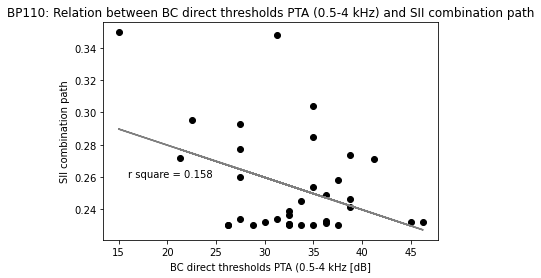

In [21]:
pta4_bp110 = (bct_bp110.iloc[:, 4]).to_numpy(dtype='float')
lrgrs = linregress(pta4_bp110, sii_bp110)
slope = lrgrs[0]
intercept = lrgrs[1]
r2 = round(lrgrs[2]**2, 3)
s = 'r square = '+ str(r2)

plt.scatter(pta4_bp110, sii_bp110, c='black')
plt.title("BP110: Relation between BC direct thresholds PTA (0.5-4 kHz) and SII combination path")
plt.xlabel("BC direct thresholds PTA (0.5-4 kHz [dB]")
plt.ylabel("SII combination path")
plt.plot(pta4_bp110, slope*pta4_bp110 + intercept, color='grey')
plt.text(16, 0.26, s)
plt.show()

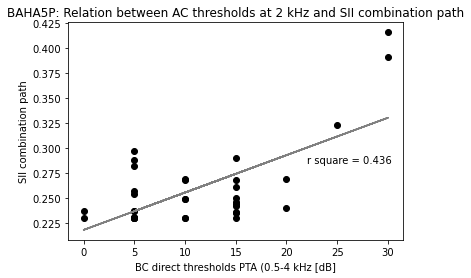

In [22]:
ac4_bh5 = (act_bh5.iloc[:, 2]).to_numpy(dtype='float')
lrgrs = linregress(ac4_bh5, sii_bh5)
slope = lrgrs[0]
intercept = lrgrs[1]
r2 = round(lrgrs[2]**2, 3)
s = 'r square = '+ str(r2)

plt.scatter(ac4_bh5, sii_bh5, c='black')
plt.title("BAHA5P: Relation between AC thresholds at 2 kHz and SII combination path")
plt.xlabel("BC direct thresholds PTA (0.5-4 kHz [dB]")
plt.ylabel("SII combination path")
plt.plot(ac4_bh5, slope*ac4_bh5 + intercept, color='grey')
plt.text(22, 0.285, s)
plt.show()